## Multi-classification problem


In [1]:
# Uncomment the next line to install packages
!pip install torch torchvision matplotlib pandas seaborn requests 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import requests
import os


import matplotlib.pyplot as plt

%matplotlib inline

## Load Data

PyTorch provides two powerful data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as prepare your own data. `Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the Dataset to enable easy access to the samples.

### USPS Dataset
* Handwritten digits with 10 classes
* 16x16 pixels for each image 
* 6 000 data examples in training set, 1 291 examples in validation set, 2 007 in test set

In [3]:
url = 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.bz2'
r = requests.get(url, allow_redirects=True)
if not os.path.isdir('USPS/'):
    os.mkdir('USPS/')
open('USPS/usps.bz2', 'wb').write(r.content)

6579383

In [4]:
# Loading USPS dataset from torchvision.dataset
dataset = torchvision.datasets.USPS(root='USPS/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=False)

In [5]:
# Get info from dataset
dataset

Dataset USPS
    Number of datapoints: 7291
    Root location: USPS/
    StandardTransform
Transform: ToTensor()

In [6]:
# Obtain the inputs and targets:
inputs = dataset.data
targets = dataset.targets

In [7]:
# Let's look at a data point
sample_index = 88

data_sample = dataset.data[sample_index]
target_sample = dataset.targets[sample_index]
print("Sample type and shape : ",type(data_sample),data_sample.shape)
print("Label type and value : " ,type(target_sample),target_sample)

Sample type and shape :  <class 'numpy.ndarray'> (16, 16)
Label type and value :  <class 'int'> 9


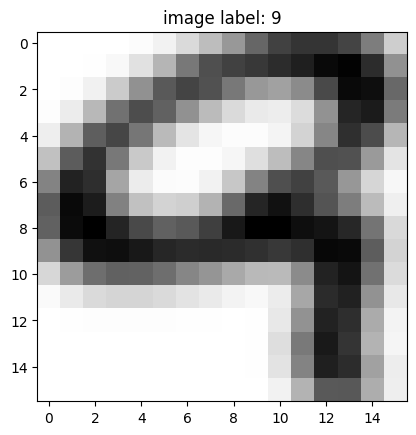

In [8]:
sample_index = 88
plt.imshow(dataset.data[sample_index], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("image label: %d" % dataset.targets[sample_index])
plt.show()

## Pytorch Tensor

Pytorch Documentation : https://pytorch.org/docs/stable/index.html

In [9]:
tensor_data_point = torch.tensor(data_sample)
print("Tensor type :",type(tensor_data_point),", and shape : ",tensor_data_point.shape)

Tensor type : <class 'torch.Tensor'> , and shape :  torch.Size([16, 16])


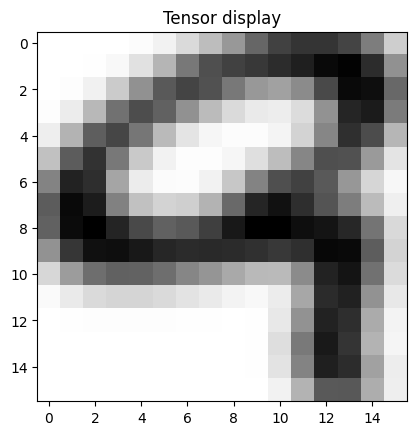

In [10]:
# Pyplot can manage torch Tensors
plt.imshow(tensor_data_point, cmap=plt.cm.gray_r)
plt.title("Tensor display")
plt.show()

In [11]:
# split the dataset to training and validation sets
train_set, val_set = random_split(dataset, [6000, 1291])

## Build your Neural Network
The `torch.nn` namespace provides all the building blocks you need to create your own neural network such as fully connected layers or convolutional layers etc. We define our neural network by subclassing `nn.Module`, and the neural network layers are initialized in **\__init\__**. Every `nn.Module` subclass implements the operations on input data in the **forward** method.

Inheritance in Python (https://www.programiz.com/python-programming/inheritance)

In [12]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        # We allocate space for the weights
        self.l1 = nn.Linear(16*16, 100)
        self.l2 = nn.Linear(100, 10)
        # Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs): # Called when we apply the network 
        h = F.relu(self.l1(inputs)) # You can put anything, as long as its Pytorch functions
        outputs = F.softmax(self.l2(h), dim=1)# Use softmax as the activation function for the last layer
        return outputs

Description of AutoGrad (https://pytorch.org/docs/stable/notes/autograd.html)

### Instantiation and forward call

In [13]:
# We initialize the Model class
my_model = Model() # it calls the init method
print(" - What is the type of my_model ?",type(my_model))
print("="*50)
print(" - Description of the internal of the Network :",my_model)
print("="*50)
print(" - Content of the first Layer :", my_model.l1.weight,)

 - What is the type of my_model ? <class '__main__.Model'>
 - Description of the internal of the Network : Model(
  (l1): Linear(in_features=256, out_features=100, bias=True)
  (l2): Linear(in_features=100, out_features=10, bias=True)
)
 - Content of the first Layer : Parameter containing:
tensor([[-0.0572,  0.0460,  0.0477,  ...,  0.0139, -0.0209,  0.0447],
        [-0.0518,  0.0079, -0.0116,  ...,  0.0314, -0.0481, -0.0618],
        [ 0.0281, -0.0610, -0.0430,  ...,  0.0456,  0.0522, -0.0362],
        ...,
        [ 0.0418, -0.0299,  0.0042,  ..., -0.0181, -0.0032, -0.0348],
        [-0.0262,  0.0580,  0.0090,  ...,  0.0370,  0.0351, -0.0500],
        [-0.0599, -0.0363, -0.0562,  ..., -0.0606, -0.0484,  0.0313]],
       requires_grad=True)


In [14]:
# Shape of the Linear Layer 
print("A :",my_model.l1.weight.shape," b : ",my_model.l1.bias.shape)

A : torch.Size([100, 256])  b :  torch.Size([100])


In [15]:
# Let's explore the forward pass
example_batch_size = 3
example_loader = DataLoader(dataset, batch_size=example_batch_size, shuffle=True)

for images,labels in example_loader:
    print("Original tensor shape",images.shape)
    print("="*50)
    print("Impact of the view method",images.view(example_batch_size,-1).shape)
    print("="*50)
    example_output = my_model(images.view(example_batch_size,-1))
    print("Shape of the output",example_output.shape)
    print("="*50)
    print("Predictions for the first image :",example_output[0].detach())
    print("="*50)
    print("Sum of all outputs : ",torch.sum(example_output[0])) # You should use detach !
    break

Original tensor shape torch.Size([3, 1, 16, 16])
Impact of the view method torch.Size([3, 256])
Shape of the output torch.Size([3, 10])
Predictions for the first image : tensor([0.0839, 0.1062, 0.1064, 0.1155, 0.0903, 0.1074, 0.0958, 0.0975, 0.0893,
        0.1076])
Sum of all outputs :  tensor(1.0000, grad_fn=<SumBackward0>)


In [16]:
# Example of One Hot Encoding

labels_one_hot = torch.FloatTensor(example_batch_size, 10)
labels_one_hot.zero_()
print("Original Labels : ",labels.detach())
print("="*50)
print("One Hot encoding :",labels_one_hot.scatter_(1, labels.view(-1, 1), 1).detach())

Original Labels :  tensor([0, 2, 4])
One Hot encoding : tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])


## Train your Model

In [17]:
# Create the model: 
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [21]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train() # Indicates to the network we are in training mode
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            y_pre = model(images.view(batch_size, -1)) 
            #reshape the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
            
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(batch_size, 10)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
           
            
            loss = criterion(y_pre, labels_one_hot) #Real number
            optimizer.zero_grad() # Set all the parameters gradient to 0
            loss.backward() # Computes  dloss/da for every parameter a which has requires_grad=True
            optimizer.step() # Updates the weights 
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [22]:
train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

Epoch [1/10], Loss: 0.0712
Epoch [2/10], Loss: 0.0589
Epoch [3/10], Loss: 0.0467
Epoch [4/10], Loss: 0.0349
Epoch [5/10], Loss: 0.0262
Epoch [6/10], Loss: 0.0207
Epoch [7/10], Loss: 0.0175
Epoch [8/10], Loss: 0.0154
Epoch [9/10], Loss: 0.0140
Epoch [10/10], Loss: 0.0129


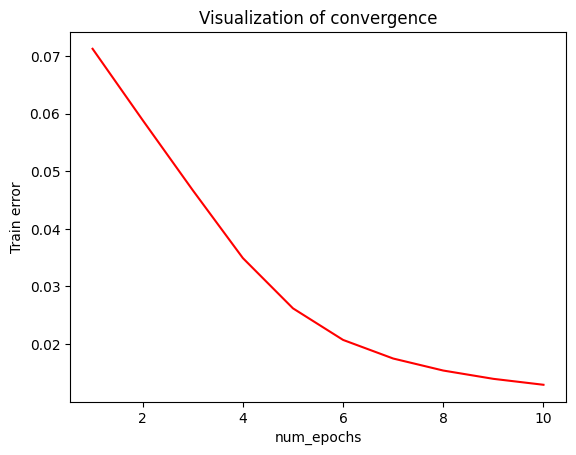

In [26]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error, color = "red")
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.show()

### Evaluate the Model on validation set

In [27]:
# Calculate the accuracy to evaluate the model
def accuracy(dataset, model):

    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            images = images.view(-1, 16*16)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  
            correct += (predicted == labels).sum()

    print('Accuracy of the model : {:.2f} %'.format(100*correct.item()/ len(dataset)))

In [28]:
accuracy(val_set, model)

Accuracy of the model : 92.72 %


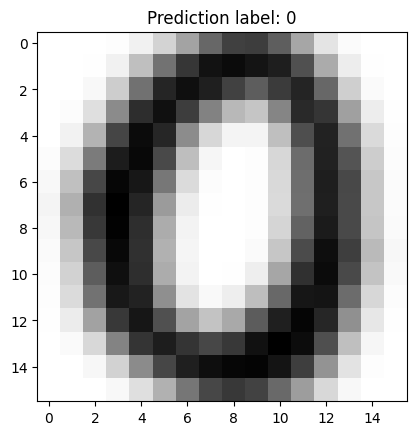

In [30]:
val_index = 66

(image, label) = val_set[val_index]
output = model(image.view(-1, 16*16))
_, prediction = torch.max(output.data, 1)

plt.imshow(image.view(16, 16), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Prediction label: %d" % prediction)
plt.show()

### Exercise 1: Impact of the architecture of the model
Define your own class `Model` to improve the predictions:

* The convolutional layer can be a good choice to deal with images. Replace nn.Linear with [nn.Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d).
* Try to add more layers (1, 2, 3, more ?)
* Change the number of neurons in hidden layers (5, 10, 20, more ?)
* Try different activation functions such as [sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.

In [49]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)  # Output: 16x16
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # Output: 16x16
        
        # Fully connected layer for classification
        self.fc = nn.Linear(64 * 16 * 16, 10)  # Map the features to 10 output classes

    def forward(self, inputs):  # Inputs expected shape: [batch_size, 1, 16, 16]
        h = F.relu(self.conv1(inputs))  # First convolution with ReLU
        h = F.relu(self.conv2(h))       # Second convolution with ReLU
        h = h.view(h.size(0), -1)       # Flatten the tensor for the fully connected layer
        outputs = F.softmax(self.fc(h), dim=1)  # Apply softmax to the final outputs
        return outputs

In [50]:
def my_train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()

    for epoch in range(num_epochs):
        epoch_average_loss = 0.0

        for images, labels in train_loader:
            # Adapter les dimensions des images pour les convolutions
            if len(images.shape) == 3:
                images = images.unsqueeze(1)

            # Encodage one-hot des labels
            labels_one_hot = torch.zeros(batch_size, 10)  # 10 = nombre de classes
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
            labels_one_hot = labels_one_hot.float()  # Conversion en float

            # Prévisions du modèle
            y_pre = model(images)

            # Calcul de la perte
            loss = criterion(y_pre, labels_one_hot)

            # Rétropropagation et mise à jour des poids
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_average_loss += loss.item() * len(images) / len(dataset)

        train_error.append(epoch_average_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_average_loss:.4f}')

    return train_error


In [51]:
mymodel = MyModel()
train_error2 = my_train(num_epochs, batch_size, criterion, optimizer, mymodel, train_set)
plt.plot(range(1, num_epochs+1), train_error2, color = "red")
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")
plt.show()

accuracy(val_set, mymodel)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x384 and 1176x64)

### Exercise 2: Impact of the optimizer
Retrain the model by using different parameters of the optimizer; you can change its parameters in the cell initializing it, after the definition of your model.

* Use different batch sizes, from 10 to 1 000 for instance
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

### Exercise 3: Impact of the loss function
The MSE error is rarely used in this case. The cross entropy loss can be a better choice for multi-classification problems. In pytorch, the cross entropy loss is defined by [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss). Replace the MSE loss by this one to observe its impact.

**Note:** In order to use nn.CrossEntropyLoss correctly, don't add an activation function to the last layer of your network. And one-hot encoding is no longer needed to calculate the loss, delete the encoding procedures in function `train`.   

### Exercise 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [ ]:
url = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.t.bz2'
r = requests.get(url, allow_redirects=True)
open('USPS/usps.t.bz2', 'wb').write(r.content)

In [ ]:
# Loading MNIST test set from torchvision.dataset
test_set = torchvision.datasets.USPS(root='USPS/',
                                         train=False,
                                         transform=transforms.ToTensor(),
                                         download=False)

In [ ]:
accuracy(test_set, model)